In [1]:
import HYLC.PatternSolver as ps
from HYLC.parallel import run_parallel
from HYLC.values import set_material_settings
import numpy as np

def make_settings():
    s = ps.SimulationSettings()
    s.pypfile = "../../pyp/prestretched/basket.pyp"
    s.pypfile = "../../pyp/prestretched/honey.pyp"
#     s.pypfile = "../../pyp/prestretched/rib.pyp"
#     s.pypfile = "../../pyp/prestretched/satin.pyp"
#     s.pypfile = "../../pyp/prestretched/stock.pyp"
    set_material_settings(s,s.pypfile)
    s.extpx = 0.6
    s.extpy = 0.6
    
    s.strains = [0,0,0,0,0,0]
    s.strains = [0.2,0.05,-0.1,20,20,20]
    
    s.newtonSettings.lagrange_epsilon = 1e-4
    s.newtonSettings.projgrad_epsilon = 1e-5
    s.newtonSettings.linear_reg_start = 5e3
    s.newtonSettings.linear_reg_stop  = 5e0
    s.newtonSettings.linear_reg_steps = 400
    s.solvableSettings.unit_Nm = 1e-6
#     s.solvableSettings.unit_Nm = 1
#     s.solvableSettings.unit_pos = 1
#     s.solvableSettings.unit_rad = 1
    return s

steps = 1

def n():
    s = make_settings()
    sim = ps.Simulation(s)
    n = sim._N()
    return n

def f(X):
    s = make_settings()
    sim = ps.Simulation(s)
    for i in range(steps):
        sim.step()
    sim._setX(X)
    f = sim._F()
    del sim
    return f

def g(X):
    s = make_settings()
    sim = ps.Simulation(s)
    for i in range(steps):
        sim.step()
    sim._setX(X)
    f = sim._G()
    del sim
    return f

def h(X):
    s = make_settings()
    sim = ps.Simulation(s)
    for i in range(steps):
        sim.step()
    sim._setX(X)
    f = sim._H()
    del sim
    return f

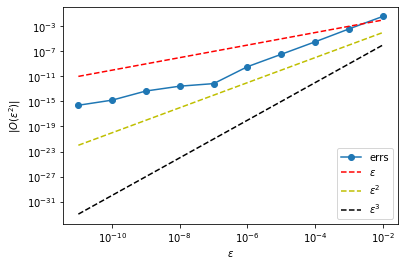

2.456058520738329e-16 0.03764514039997836


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_FD_check(epss,ndof,f,g):
    errs = np.empty((len(epss),),dtype=np.float)
    for i,eps in enumerate(epss):
        x = np.zeros((ndof,))
        dx = np.random.uniform(-1,1,size=x.shape)
        dx /= np.linalg.norm(dx)
        F0 = f(x)
        G0 = g(x)
        F1 = f(x + eps * dx)
        err = np.linalg.norm(F1 - F0 - G0 @ (eps * dx)) # f(x+epsdx) = f(x) + dfdx(x) @ epsdx + O(eps^2)
        errs[i] = err
    
    plt.plot(epss,errs, '-o', label="errs")
    plt.plot(epss,epss, 'r--', label='$\epsilon$')
    plt.plot(epss,epss**2, 'y--', label='$\epsilon^2$')
    plt.plot(epss,epss**3, 'k--', label='$\epsilon^3$')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("$\epsilon$")
    plt.ylabel("|$O(\epsilon^2)$|")
    plt.legend(loc='lower right');
    plt.show()
    print(errs.min(),errs.max())
    
ndof = n()
ps.setDebug("no_DER_force",False)
ps.setDebug("no_COL_force",False)
plot_FD_check(np.logspace(-11,-2,10),ndof,f,g)          

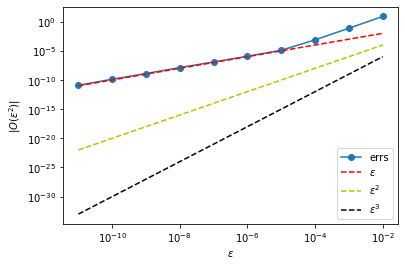

1.2507328228216852e-11 7.875964497065259


In [3]:
# ONLY DER
ps.setDebug("no_DER_force",False)
ps.setDebug("no_COL_force",True)
plot_FD_check(np.logspace(-11,-2,10),ndof,g,h)

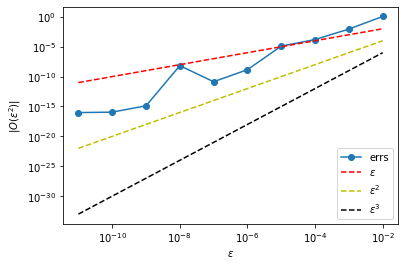

9.586928014516583e-17 1.1520262963484404


In [4]:
# ONLY COLLISION
ps.setDebug("no_DER_force",True)
ps.setDebug("no_COL_force",False)
plot_FD_check(np.logspace(-11,-2,10),ndof,g,h)

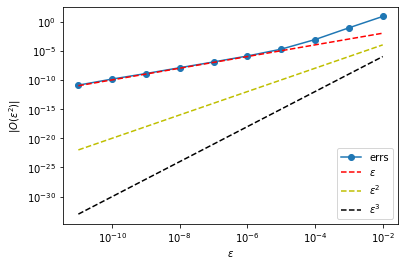

1.2648852347338304e-11 7.438019648370496


In [5]:
ps.setDebug("no_DER_force",False)
ps.setDebug("no_COL_force",False)
plot_FD_check(np.logspace(-11,-2,10),ndof,g,h)